In [49]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir('/Users/stevengeorge/Documents/Github/fpl-analysis')

from src.models.constants import STATIC_FEATURES, TIME_SERIES_FEATURES
from src.data.live_season_data import GetFPLData
from src.features.custom_transformers import TimeSeriesFeatures

pd.set_option('display.max_columns', None)

DATA_PATH = 'data/processed/'

### Historical data

In [93]:
fpl_data_all_seasons = pd.read_parquet(DATA_PATH + 'fpl_data_2016_to_2019.parquet')
print(fpl_data_all_seasons.shape)
fpl_data_all_seasons.head()

(67986, 73)


,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,ID
0,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,14023,0,0,0,1,2,0.0,0,0,0,0,5.5,False,0,0,1,2016-17,West Ham United,0,0,1,0,0,0,Chelsea,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
1,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,5.5,True,0,0,2,2016-17,West Ham United,0,0,1,0,0,0,Bournemouth,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,5.4,False,0,0,3,2016-17,West Ham United,0,0,1,0,0,0,Manchester City,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
3,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,5.4,True,0,0,4,2016-17,West Ham United,0,0,1,0,0,0,Watford,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7933,0,0,0,2,4,0.0,0,-520,29,549,5.4,False,0,0,5,2016-17,West Ham United,0,0,1,0,0,0,West Bromwich Albion,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [94]:
# Columns used to train GW2 model
AVAILABLE_COLUMNS = [
    'name', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'minutes', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
    'saves', 'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points', 'transfers_balance', 'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards', 'gw', 'season', 'team_name',
    'promoted_side', 'top_6_last_season', 'position_DEF', 'position_FWD', 'position_GK', 'position_MID', 'team_name_opponent', 'promoted_side_opponent', 'top_6_last_season_opponent', 'kickoff_month_Aug',
    'late_kickoff', 'early_kickoff', 'ID', 'kickoff_month_Apr', 'kickoff_month_Dec', 'kickoff_month_Feb', 'kickoff_month_Jan', 'kickoff_month_Mar', 'kickoff_month_May', 'kickoff_month_Nov', 'kickoff_month_Oct',
    'kickoff_month_Sep'
]

In [4]:
fpl_data_all_seasons = fpl_data_all_seasons[AVAILABLE_COLUMNS]
fpl_data_all_seasons.shape

(67986, 52)

In [5]:
fpl_data_all_seasons['season_order'] = fpl_data_all_seasons['season'].map({
    '2016-17': 1,
    '2017-18': 2,
    '2018-19': 3,
    '2019-20': 4
})

In [6]:
fpl_data_all_seasons.sort_values(['name', 'season_order', 'gw'], inplace=True)
fpl_data_all_seasons.reset_index(drop=True, inplace=True)

__Shift forward static features e.g. next opponent etc.__

In [7]:
for feature in ['value', 'was_home', 'promoted_side_opponent', 'top_6_last_season_opponent', 'kickoff_month_Apr', 'kickoff_month_Aug', 'kickoff_month_Dec',
                'kickoff_month_Feb', 'kickoff_month_Jan', 'kickoff_month_Mar', 'kickoff_month_May', 'kickoff_month_Nov', 'kickoff_month_Oct', 
                'kickoff_month_Sep', 'late_kickoff', 'early_kickoff']:
    fpl_data_all_seasons[f'next_match_{feature}'] = fpl_data_all_seasons.groupby('name')[f'{feature}'].shift(-1)

### Create time series features

Create new ID

In [8]:
fpl_data_all_seasons.drop('ID', axis=1, inplace=True)

In [9]:
id_df = fpl_data_all_seasons.groupby(['name']).count().reset_index()[['name']]
id_df['ID'] = id_df.index + 1
print(id_df.shape)
id_df.head()

(1090, 2)


,name,ID
0,aaron_cresswell,1
1,aaron_lennon,2
2,aaron_mooy,3
3,aaron_ramsdale,4
4,aaron_ramsey,5


In [10]:
fpl_data_all_seasons = fpl_data_all_seasons.merge(id_df, how='left', on=['name'])

In [11]:
TIME_SERIES_FEATURES_LITE = list(set(AVAILABLE_COLUMNS).intersection(TIME_SERIES_FEATURES))

In [12]:
ts_features = TimeSeriesFeatures(halflife=4, max_lag=4, max_diff=4, columns=TIME_SERIES_FEATURES_LITE)

In [13]:
fpl_data_all_seasons[TIME_SERIES_FEATURES_LITE].info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67986 entries, 0 to 67985
Data columns (total 25 columns):
goals_conceded       67986 non-null int64
team_a_score         67986 non-null int64
yellow_cards         67986 non-null int64
red_cards            67986 non-null int64
clean_sheets         67986 non-null int64
threat               67986 non-null float64
transfers_in         67986 non-null int64
total_points         67986 non-null int64
transfers_out        67986 non-null int64
transfers_balance    67986 non-null int64
ict_index            67986 non-null float64
penalties_missed     67986 non-null int64
goals_scored         67986 non-null int64
penalties_saved      67986 non-null int64
bonus                67986 non-null int64
influence            67986 non-null float64
selected             67986 non-null int64
value                67986 non-null float64
creativity           67986 non-null float64
own_goals            67986 non-null int64
team_h_score         67986 non-null int64

In [14]:
for col in TIME_SERIES_FEATURES_LITE:
    fpl_data_all_seasons[col] = pd.to_numeric(fpl_data_all_seasons[col])

In [15]:
%%time
fpl_data_all_seasons_with_ts = ts_features.fit_transform(fpl_data_all_seasons)
print(fpl_data_all_seasons.shape)

(67986, 69)
CPU times: user 2min 16s, sys: 42.7 s, total: 2min 58s
Wall time: 2min 48s


In [16]:
fpl_data_all_seasons_with_ts.head()

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,ID,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,goals_conceded_L3,goals_conceded_L4,goals_conceded_D1,goals_conceded_D2,goals_conceded_D3,goals_conceded_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_L3,red_cards_L4,red_cards_D1,red_cards_D2,red_cards_D3,red_cards_D4,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,clean_sheets_L3,clean_sheets_L4,clean_sheets_D1,clean_sheets_D2,clean_sheets_D3,clean_sheets_D4,threat_EMA,threat_L1,threat_L2,threat_L3,threat_L4,threat_D1,threat_D2,threat_D3,threat_D4,transfers_in_EMA,transfers_in_L1,transfers_in_L2,transfers_in_L3,transfers_in_L4,transfers_in_D1,transfers_in_D2,transfers_in_D3,transfers_in_D4,total_points_EMA,total_points_L1,total_points_L2,total_points_L3,total_points_L4,total_points_D1,total_points_D2,total_points_D3,total_points_D4,transfers_out_EMA,transfers_out_L1,transfers_out_L2,transfers_out_L3,transfers_out_L4,transfers_out_D1,transfers_out_D2,transfers_out_D3,transfers_out_D4,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,transfers_balance_L3,transfers_balance_L4,transfers_balance_D1,transfers_balance_D2,transfers_balance_D3,transfers_balance_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,penalties_missed_EMA,penalties_missed_L1,penalties_missed_L2,penalties_missed_L3,penalties_missed_L4,penalties_missed_D1,penalties_missed_D2,penalties_missed_D3,penalties_missed_D4,goals_scored_EMA,goals_scored_L1,goals_scored_L2,goals_scored_L3,goals_scored_L4,goals_scored_D1,goals_scored_D2,goals_scored_D3,goals_scored_D4,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,penalties_saved_L3,penalties_saved_L4,penalties_saved_D1,penalties_saved_D2,penalties_saved_D3,penalties_saved_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,influence_EMA,influence_L1,influence_L2,influence_L3,influence_L4,influence_D1,influence_D2,influence_D3,influence_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,value_EMA,value_L1,value_L2,value_L3,value_L4,value_D1,value_D2,value_D3,value_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,own_goals_EMA,own_goals_L1,own_goals_L2,own_goals_L3,own_goals_L4,own_goals_D1,own_goals_D2,own_goals_D3,own_goals_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,bps_EMA,bps_L1,bps_L2,bps_L3

### Train model

In [17]:
fpl_data_all_seasons_with_ts_full = fpl_data_all_seasons_with_ts.copy()

In [18]:
fpl_data_all_seasons_with_ts = fpl_data_all_seasons_with_ts[fpl_data_all_seasons_with_ts['season_order'] != 3]

In [19]:
import lightgbm

/anaconda3/envs/fpl_analysis/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [20]:
fpl_data_all_seasons_with_ts['total_points_plus_1_gw'] = fpl_data_all_seasons_with_ts.groupby(['name'])['total_points'].shift(-1)

In [21]:
fpl_data_all_seasons_with_ts = fpl_data_all_seasons_with_ts[~fpl_data_all_seasons_with_ts['total_points_plus_1_gw'].isnull()]

In [22]:
gs_params = {
    'learning_rate': 0.03,
     'max_depth': -1,
     'n_estimators': 200,
     'num_leaves': 50,
     'reg_alpha': 0.03
}
lgbm_model = lightgbm.LGBMRegressor(**gs_params)

In [23]:
fpl_data_all_seasons_with_ts['next_match_was_home'] = fpl_data_all_seasons_with_ts['next_match_was_home'].astype(bool)

In [24]:
%%time
lgbm_model.fit(
    fpl_data_all_seasons_with_ts.drop(
        ['name', 'season', 'team_name', 'team_name_opponent', 'total_points_plus_1_gw', 'ID'],
        axis=1
    ),
    fpl_data_all_seasons_with_ts['total_points_plus_1_gw']
)

CPU times: user 1min 15s, sys: 3.13 s, total: 1min 18s
Wall time: 28.4 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.03, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=50, objective=None,
              random_state=None, reg_alpha=0.03, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [25]:
predictions = lgbm_model.predict(
    fpl_data_all_seasons_with_ts.drop(
        ['name', 'season', 'team_name', 'team_name_opponent', 'total_points_plus_1_gw', 'ID'],
        axis=1
    )
)

In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
mean_squared_error(fpl_data_all_seasons_with_ts['total_points_plus_1_gw'], predictions)

3.097759850591169

In [28]:
import shap

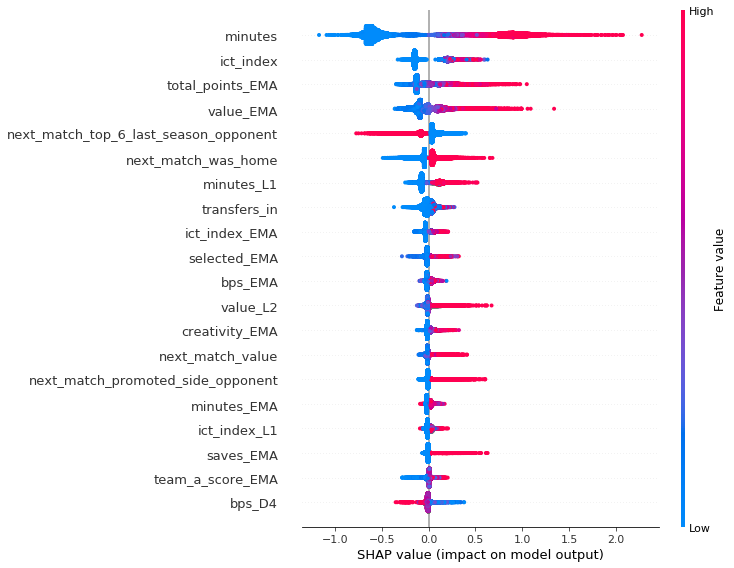

In [29]:
# LightGBM shap
shap_values = shap.TreeExplainer(lgbm_model).shap_values(
    fpl_data_all_seasons_with_ts.drop(
        ['name', 'season', 'team_name', 'team_name_opponent', 'total_points_plus_1_gw', 'ID'],
        axis=1
    )
)

shap.summary_plot(
    shap_values,
    fpl_data_all_seasons_with_ts.drop(
        ['name', 'season', 'team_name', 'team_name_opponent', 'total_points_plus_1_gw', 'ID'],
        axis=1
    )
)

### Make predictions

In [30]:
test = fpl_data_all_seasons_with_ts_full[
    (fpl_data_all_seasons_with_ts_full['season_order'] == 3)
]

In [31]:
test.head()

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,ID,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,goals_conceded_L3,goals_conceded_L4,goals_conceded_D1,goals_conceded_D2,goals_conceded_D3,goals_conceded_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_L3,red_cards_L4,red_cards_D1,red_cards_D2,red_cards_D3,red_cards_D4,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,clean_sheets_L3,clean_sheets_L4,clean_sheets_D1,clean_sheets_D2,clean_sheets_D3,clean_sheets_D4,threat_EMA,threat_L1,threat_L2,threat_L3,threat_L4,threat_D1,threat_D2,threat_D3,threat_D4,transfers_in_EMA,transfers_in_L1,transfers_in_L2,transfers_in_L3,transfers_in_L4,transfers_in_D1,transfers_in_D2,transfers_in_D3,transfers_in_D4,total_points_EMA,total_points_L1,total_points_L2,total_points_L3,total_points_L4,total_points_D1,total_points_D2,total_points_D3,total_points_D4,transfers_out_EMA,transfers_out_L1,transfers_out_L2,transfers_out_L3,transfers_out_L4,transfers_out_D1,transfers_out_D2,transfers_out_D3,transfers_out_D4,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,transfers_balance_L3,transfers_balance_L4,transfers_balance_D1,transfers_balance_D2,transfers_balance_D3,transfers_balance_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,penalties_missed_EMA,penalties_missed_L1,penalties_missed_L2,penalties_missed_L3,penalties_missed_L4,penalties_missed_D1,penalties_missed_D2,penalties_missed_D3,penalties_missed_D4,goals_scored_EMA,goals_scored_L1,goals_scored_L2,goals_scored_L3,goals_scored_L4,goals_scored_D1,goals_scored_D2,goals_scored_D3,goals_scored_D4,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,penalties_saved_L3,penalties_saved_L4,penalties_saved_D1,penalties_saved_D2,penalties_saved_D3,penalties_saved_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,influence_EMA,influence_L1,influence_L2,influence_L3,influence_L4,influence_D1,influence_D2,influence_D3,influence_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,value_EMA,value_L1,value_L2,value_L3,value_L4,value_D1,value_D2,value_D3,value_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,own_goals_EMA,own_goals_L1,own_goals_L2,own_goals_L3,own_goals_L4,own_goals_D1,own_goals_D2,own_goals_D3,own_goals_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,bps_EMA,bps_L1,bps_L2,bps_L3

In [32]:
test_copy = test.copy()

In [33]:
test_copy['total_points_plus_1_gw'] = test_copy.groupby(['name'])['total_points'].shift(-1)

In [34]:
test_copy = test_copy[~test_copy['total_points_plus_1_gw'].isnull()]

In [35]:
test_copy = test_copy[(test_copy['gw'] == 2)]

In [36]:
test_copy['next_match_was_home'] = test_copy['next_match_was_home'].astype(bool)

In [37]:
predictions_gw3_201920 = lgbm_model.predict(
    test_copy.drop(
        ['name', 'season', 'team_name', 'team_name_opponent', 'total_points_plus_1_gw', 'ID'],
        axis=1
    )
)

In [38]:
test_copy['predictions'] = predictions_gw3_201920

In [39]:
test_copy.sort_values('predictions', inplace=True, ascending=False)

In [40]:
test_copy.head(10)

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,ID,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,goals_conceded_L3,goals_conceded_L4,goals_conceded_D1,goals_conceded_D2,goals_conceded_D3,goals_conceded_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_L3,red_cards_L4,red_cards_D1,red_cards_D2,red_cards_D3,red_cards_D4,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,clean_sheets_L3,clean_sheets_L4,clean_sheets_D1,clean_sheets_D2,clean_sheets_D3,clean_sheets_D4,threat_EMA,threat_L1,threat_L2,threat_L3,threat_L4,threat_D1,threat_D2,threat_D3,threat_D4,transfers_in_EMA,transfers_in_L1,transfers_in_L2,transfers_in_L3,transfers_in_L4,transfers_in_D1,transfers_in_D2,transfers_in_D3,transfers_in_D4,total_points_EMA,total_points_L1,total_points_L2,total_points_L3,total_points_L4,total_points_D1,total_points_D2,total_points_D3,total_points_D4,transfers_out_EMA,transfers_out_L1,transfers_out_L2,transfers_out_L3,transfers_out_L4,transfers_out_D1,transfers_out_D2,transfers_out_D3,transfers_out_D4,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,transfers_balance_L3,transfers_balance_L4,transfers_balance_D1,transfers_balance_D2,transfers_balance_D3,transfers_balance_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,penalties_missed_EMA,penalties_missed_L1,penalties_missed_L2,penalties_missed_L3,penalties_missed_L4,penalties_missed_D1,penalties_missed_D2,penalties_missed_D3,penalties_missed_D4,goals_scored_EMA,goals_scored_L1,goals_scored_L2,goals_scored_L3,goals_scored_L4,goals_scored_D1,goals_scored_D2,goals_scored_D3,goals_scored_D4,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,penalties_saved_L3,penalties_saved_L4,penalties_saved_D1,penalties_saved_D2,penalties_saved_D3,penalties_saved_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,influence_EMA,influence_L1,influence_L2,influence_L3,influence_L4,influence_D1,influence_D2,influence_D3,influence_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,value_EMA,value_L1,value_L2,value_L3,value_L4,value_D1,value_D2,value_D3,value_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,own_goals_EMA,own_goals_L1,own_goals_L2,own_goals_L3,own_goals_L4,own_goals_D1,own_goals_D2,own_goals_D3,own_goals_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,bps_EMA,bps_L1,bps_L2,bps_L3

In [41]:
test_copy = test_copy[['name', 'position_DEF', 'position_FWD', 'position_GK', 'position_MID', 'predictions', 'team_name', 'next_match_value', 'total_points_plus_1_gw']]
test_copy.head()

,name,position_DEF,position_FWD,position_GK,position_MID,predictions,team_name,next_match_value,total_points_plus_1_gw
53713,pierre-emerick_aubameyang,0,1,0,0,7.927379,Arsenal,11.0,2.0
47939,mohamed_salah,0,0,0,1,6.964351,Liverpool,13.0,8.0
57455,sadio_mané,0,0,0,1,6.003159,Liverpool,9.8,3.0
23225,gabriel fernando_de jesus,0,1,0,0,5.366535,Manchester City,10.5,1.0
59519,sergio_agüero,0,1,0,0,5.246218,Manchester City,11.2,2.0


In [42]:
test_copy.tail()

,name,position_DEF,position_FWD,position_GK,position_MID,predictions,team_name,next_match_value,total_points_plus_1_gw
57835,sam_byram,1,0,0,0,0.066333,West Ham United,4.5,0.0
43854,markus_suttner,1,0,0,0,0.061367,Brighton & Hove Albion,4.0,0.0
57721,sam_baldock,0,1,0,0,0.059079,Brighton & Hove Albion,4.5,0.0
11251,chancel_mbemba,1,0,0,0,-0.055135,Newcastle United,4.0,0.0
55594,robert_elliot,0,0,1,0,-0.058448,Newcastle United,4.5,0.0


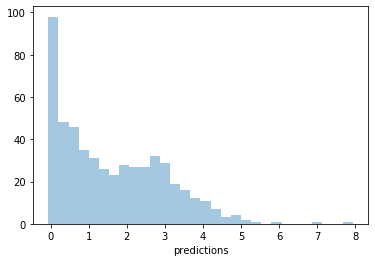

In [43]:
sns.distplot(test_copy['predictions'], kde=False, bins=30)

In [44]:
mean_squared_error(test_copy['total_points_plus_1_gw'], test_copy['predictions'])

4.167121029397524

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

/anaconda3/envs/fpl_analysis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


<module 'matplotlib.pyplot' from '/anaconda3/envs/fpl_analysis/lib/python3.7/site-packages/matplotlib/pyplot.py'>

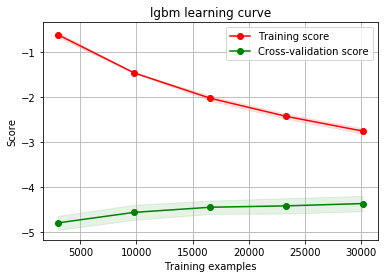

In [93]:
plot_learning_curve(
    estimator=lgbm_model,
    title='lgbm learning curve',
    X=fpl_data_all_seasons_with_ts.drop(
        ['total_points', 'name', 'season', 'team_name', 'team_name_opponent', 'total_points_plus_1_gw', 'ID'],
        axis=1
    ),
    y=fpl_data_all_seasons_with_ts['total_points_plus_1_gw'],
)

## Build model to predict minutes played

In [50]:
fpl_data_all_seasons_with_ts_new_model_data = fpl_data_all_seasons_with_ts_full[fpl_data_all_seasons_with_ts_full['season_order'] != 3]

In [51]:
fpl_data_all_seasons_with_ts_new_model_data.head()

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,ID,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,goals_conceded_L3,goals_conceded_L4,goals_conceded_D1,goals_conceded_D2,goals_conceded_D3,goals_conceded_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_L3,red_cards_L4,red_cards_D1,red_cards_D2,red_cards_D3,red_cards_D4,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,clean_sheets_L3,clean_sheets_L4,clean_sheets_D1,clean_sheets_D2,clean_sheets_D3,clean_sheets_D4,threat_EMA,threat_L1,threat_L2,threat_L3,threat_L4,threat_D1,threat_D2,threat_D3,threat_D4,transfers_in_EMA,transfers_in_L1,transfers_in_L2,transfers_in_L3,transfers_in_L4,transfers_in_D1,transfers_in_D2,transfers_in_D3,transfers_in_D4,total_points_EMA,total_points_L1,total_points_L2,total_points_L3,total_points_L4,total_points_D1,total_points_D2,total_points_D3,total_points_D4,transfers_out_EMA,transfers_out_L1,transfers_out_L2,transfers_out_L3,transfers_out_L4,transfers_out_D1,transfers_out_D2,transfers_out_D3,transfers_out_D4,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,transfers_balance_L3,transfers_balance_L4,transfers_balance_D1,transfers_balance_D2,transfers_balance_D3,transfers_balance_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,penalties_missed_EMA,penalties_missed_L1,penalties_missed_L2,penalties_missed_L3,penalties_missed_L4,penalties_missed_D1,penalties_missed_D2,penalties_missed_D3,penalties_missed_D4,goals_scored_EMA,goals_scored_L1,goals_scored_L2,goals_scored_L3,goals_scored_L4,goals_scored_D1,goals_scored_D2,goals_scored_D3,goals_scored_D4,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,penalties_saved_L3,penalties_saved_L4,penalties_saved_D1,penalties_saved_D2,penalties_saved_D3,penalties_saved_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,influence_EMA,influence_L1,influence_L2,influence_L3,influence_L4,influence_D1,influence_D2,influence_D3,influence_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,value_EMA,value_L1,value_L2,value_L3,value_L4,value_D1,value_D2,value_D3,value_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,own_goals_EMA,own_goals_L1,own_goals_L2,own_goals_L3,own_goals_L4,own_goals_D1,own_goals_D2,own_goals_D3,own_goals_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,bps_EMA,bps_L1,bps_L2,bps_L3

In [52]:
fpl_data_all_seasons_with_ts_new_model_data['played'] = np.where(
    fpl_data_all_seasons_with_ts_new_model_data['minutes'] == 0,
    0,
    1
)
fpl_data_all_seasons_with_ts_new_model_data.head()

/anaconda3/envs/fpl_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,ID,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,goals_conceded_L3,goals_conceded_L4,goals_conceded_D1,goals_conceded_D2,goals_conceded_D3,goals_conceded_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_L3,red_cards_L4,red_cards_D1,red_cards_D2,red_cards_D3,red_cards_D4,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,clean_sheets_L3,clean_sheets_L4,clean_sheets_D1,clean_sheets_D2,clean_sheets_D3,clean_sheets_D4,threat_EMA,threat_L1,threat_L2,threat_L3,threat_L4,threat_D1,threat_D2,threat_D3,threat_D4,transfers_in_EMA,transfers_in_L1,transfers_in_L2,transfers_in_L3,transfers_in_L4,transfers_in_D1,transfers_in_D2,transfers_in_D3,transfers_in_D4,total_points_EMA,total_points_L1,total_points_L2,total_points_L3,total_points_L4,total_points_D1,total_points_D2,total_points_D3,total_points_D4,transfers_out_EMA,transfers_out_L1,transfers_out_L2,transfers_out_L3,transfers_out_L4,transfers_out_D1,transfers_out_D2,transfers_out_D3,transfers_out_D4,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,transfers_balance_L3,transfers_balance_L4,transfers_balance_D1,transfers_balance_D2,transfers_balance_D3,transfers_balance_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,penalties_missed_EMA,penalties_missed_L1,penalties_missed_L2,penalties_missed_L3,penalties_missed_L4,penalties_missed_D1,penalties_missed_D2,penalties_missed_D3,penalties_missed_D4,goals_scored_EMA,goals_scored_L1,goals_scored_L2,goals_scored_L3,goals_scored_L4,goals_scored_D1,goals_scored_D2,goals_scored_D3,goals_scored_D4,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,penalties_saved_L3,penalties_saved_L4,penalties_saved_D1,penalties_saved_D2,penalties_saved_D3,penalties_saved_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,influence_EMA,influence_L1,influence_L2,influence_L3,influence_L4,influence_D1,influence_D2,influence_D3,influence_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,value_EMA,value_L1,value_L2,value_L3,value_L4,value_D1,value_D2,value_D3,value_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,own_goals_EMA,own_goals_L1,own_goals_L2,own_goals_L3,own_goals_L4,own_goals_D1,own_goals_D2,own_goals_D3,own_goals_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,bps_EMA,bps_L1,bps_L2,bps_L3

In [53]:
fpl_data_all_seasons_with_ts_new_model_data['played_plus_1_gw'] = fpl_data_all_seasons_with_ts_new_model_data.groupby(['name'])['played'].shift(-1)

/anaconda3/envs/fpl_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [54]:
fpl_data_all_seasons_with_ts_new_model_data = fpl_data_all_seasons_with_ts_new_model_data[
    ~fpl_data_all_seasons_with_ts_new_model_data['played_plus_1_gw'].isnull()
]

In [55]:
fpl_data_all_seasons_with_ts_new_model_data.head()

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,ID,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,goals_conceded_L3,goals_conceded_L4,goals_conceded_D1,goals_conceded_D2,goals_conceded_D3,goals_conceded_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_L3,red_cards_L4,red_cards_D1,red_cards_D2,red_cards_D3,red_cards_D4,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,clean_sheets_L3,clean_sheets_L4,clean_sheets_D1,clean_sheets_D2,clean_sheets_D3,clean_sheets_D4,threat_EMA,threat_L1,threat_L2,threat_L3,threat_L4,threat_D1,threat_D2,threat_D3,threat_D4,transfers_in_EMA,transfers_in_L1,transfers_in_L2,transfers_in_L3,transfers_in_L4,transfers_in_D1,transfers_in_D2,transfers_in_D3,transfers_in_D4,total_points_EMA,total_points_L1,total_points_L2,total_points_L3,total_points_L4,total_points_D1,total_points_D2,total_points_D3,total_points_D4,transfers_out_EMA,transfers_out_L1,transfers_out_L2,transfers_out_L3,transfers_out_L4,transfers_out_D1,transfers_out_D2,transfers_out_D3,transfers_out_D4,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,transfers_balance_L3,transfers_balance_L4,transfers_balance_D1,transfers_balance_D2,transfers_balance_D3,transfers_balance_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,penalties_missed_EMA,penalties_missed_L1,penalties_missed_L2,penalties_missed_L3,penalties_missed_L4,penalties_missed_D1,penalties_missed_D2,penalties_missed_D3,penalties_missed_D4,goals_scored_EMA,goals_scored_L1,goals_scored_L2,goals_scored_L3,goals_scored_L4,goals_scored_D1,goals_scored_D2,goals_scored_D3,goals_scored_D4,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,penalties_saved_L3,penalties_saved_L4,penalties_saved_D1,penalties_saved_D2,penalties_saved_D3,penalties_saved_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,influence_EMA,influence_L1,influence_L2,influence_L3,influence_L4,influence_D1,influence_D2,influence_D3,influence_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,value_EMA,value_L1,value_L2,value_L3,value_L4,value_D1,value_D2,value_D3,value_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,own_goals_EMA,own_goals_L1,own_goals_L2,own_goals_L3,own_goals_L4,own_goals_D1,own_goals_D2,own_goals_D3,own_goals_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,bps_EMA,bps_L1,bps_L2,bps_L3

In [56]:
fpl_data_all_seasons_with_ts_new_model_data['next_match_was_home'] = fpl_data_all_seasons_with_ts_new_model_data['next_match_was_home'].astype(bool)

In [57]:
lgbm_played = lightgbm.LGBMClassifier()

In [58]:
%%time
lgbm_played.fit(
    fpl_data_all_seasons_with_ts_new_model_data.drop(
        ['name', 'season', 'team_name', 'team_name_opponent', 'played_plus_1_gw', 'ID'],
        axis=1
    ),
    fpl_data_all_seasons_with_ts_new_model_data['played_plus_1_gw']
)

CPU times: user 27.7 s, sys: 1.96 s, total: 29.7 s
Wall time: 11.7 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [59]:
predictions_played = lgbm_played.predict(
    fpl_data_all_seasons_with_ts_new_model_data.drop(
        ['name', 'season', 'team_name', 'team_name_opponent', 'played_plus_1_gw', 'ID'],
        axis=1
    )
)

In [62]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [61]:
accuracy_score(fpl_data_all_seasons_with_ts_new_model_data['played_plus_1_gw'], predictions_played)

0.8788039514685407

In [63]:
predictions_played_proba = lgbm_played.predict_proba(
    fpl_data_all_seasons_with_ts_new_model_data.drop(
        ['name', 'season', 'team_name', 'team_name_opponent', 'played_plus_1_gw', 'ID'],
        axis=1
    )
)

In [65]:
fpl_data_all_seasons_with_ts_new_model_data['played_plus_1_gw'].shape

(45249,)

In [70]:
roc_auc_score(fpl_data_all_seasons_with_ts_new_model_data['played_plus_1_gw'], predictions_played_proba[:, 1])

0.9533652386546294

## Model to predict total points when minutes > 0

In [96]:
fpl_data_all_seasons_with_ts_new_reg = fpl_data_all_seasons_with_ts_full[fpl_data_all_seasons_with_ts_full['season_order'] != 3]

In [97]:
fpl_data_all_seasons_with_ts_new_reg['total_points_plus_1_gw'] = fpl_data_all_seasons_with_ts_new_reg.groupby(['name'])['total_points'].shift(-1)

/anaconda3/envs/fpl_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [98]:
fpl_data_all_seasons_with_ts_new_reg = fpl_data_all_seasons_with_ts_new_reg[~fpl_data_all_seasons_with_ts_new_reg['total_points_plus_1_gw'].isnull()]

In [99]:
fpl_data_all_seasons_with_ts_new_reg['played'] = np.where(
    fpl_data_all_seasons_with_ts_new_reg['minutes'] == 0,
    0,
    1
)

In [100]:
fpl_data_all_seasons_with_ts_new_reg['played_plus_1_gw'] = fpl_data_all_seasons_with_ts_new_reg.groupby(['name'])['played'].shift(-1)

In [101]:
player_gw_zero_points_next = fpl_data_all_seasons_with_ts_new_reg.copy()[fpl_data_all_seasons_with_ts_new_reg['played_plus_1_gw'] == 0]

In [102]:
# Only keep player-gameweeks where they scored points in the following gameweek
fpl_data_all_seasons_with_ts_new_reg = fpl_data_all_seasons_with_ts_new_reg[fpl_data_all_seasons_with_ts_new_reg['played_plus_1_gw'] == 1]

In [103]:
gs_params = {
    'learning_rate': 0.03,
     'max_depth': -1,
     'n_estimators': 200,
     'num_leaves': 50,
     'reg_alpha': 0.03
}
lgbm_model = lightgbm.LGBMRegressor(**gs_params)

In [104]:
fpl_data_all_seasons_with_ts_new_reg['next_match_was_home'] = fpl_data_all_seasons_with_ts_new_reg['next_match_was_home'].astype(bool)

In [105]:
%%time
lgbm_model.fit(
    fpl_data_all_seasons_with_ts_new_reg.drop(
        ['name', 'season', 'team_name', 'team_name_opponent', 'total_points_plus_1_gw', 'ID'],
        axis=1
    ),
    fpl_data_all_seasons_with_ts_new_reg['total_points_plus_1_gw']
)

CPU times: user 44.9 s, sys: 973 ms, total: 45.9 s
Wall time: 13 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.03, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=50, objective=None,
              random_state=None, reg_alpha=0.03, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [106]:
predictions = lgbm_model.predict(
    fpl_data_all_seasons_with_ts_new_reg.drop(
        ['name', 'season', 'team_name', 'team_name_opponent', 'total_points_plus_1_gw', 'ID'],
        axis=1
    )
)

In [107]:
from sklearn.metrics import mean_squared_error

In [112]:
fpl_data_all_seasons_with_ts_new_reg['predictions'] = predictions

In [113]:
mean_squared_error(fpl_data_all_seasons_with_ts_new_reg['total_points_plus_1_gw'], fpl_data_all_seasons_with_ts_new_reg['predictions'])

5.154344540148084

In [114]:
fpl_data_all_seasons_with_ts_new_reg.head()

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,ID,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,goals_conceded_L3,goals_conceded_L4,goals_conceded_D1,goals_conceded_D2,goals_conceded_D3,goals_conceded_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yellow_cards_D3,yellow_cards_D4,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_L3,red_cards_L4,red_cards_D1,red_cards_D2,red_cards_D3,red_cards_D4,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,clean_sheets_L3,clean_sheets_L4,clean_sheets_D1,clean_sheets_D2,clean_sheets_D3,clean_sheets_D4,threat_EMA,threat_L1,threat_L2,threat_L3,threat_L4,threat_D1,threat_D2,threat_D3,threat_D4,transfers_in_EMA,transfers_in_L1,transfers_in_L2,transfers_in_L3,transfers_in_L4,transfers_in_D1,transfers_in_D2,transfers_in_D3,transfers_in_D4,total_points_EMA,total_points_L1,total_points_L2,total_points_L3,total_points_L4,total_points_D1,total_points_D2,total_points_D3,total_points_D4,transfers_out_EMA,transfers_out_L1,transfers_out_L2,transfers_out_L3,transfers_out_L4,transfers_out_D1,transfers_out_D2,transfers_out_D3,transfers_out_D4,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,transfers_balance_L3,transfers_balance_L4,transfers_balance_D1,transfers_balance_D2,transfers_balance_D3,transfers_balance_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,penalties_missed_EMA,penalties_missed_L1,penalties_missed_L2,penalties_missed_L3,penalties_missed_L4,penalties_missed_D1,penalties_missed_D2,penalties_missed_D3,penalties_missed_D4,goals_scored_EMA,goals_scored_L1,goals_scored_L2,goals_scored_L3,goals_scored_L4,goals_scored_D1,goals_scored_D2,goals_scored_D3,goals_scored_D4,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,penalties_saved_L3,penalties_saved_L4,penalties_saved_D1,penalties_saved_D2,penalties_saved_D3,penalties_saved_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,influence_EMA,influence_L1,influence_L2,influence_L3,influence_L4,influence_D1,influence_D2,influence_D3,influence_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,value_EMA,value_L1,value_L2,value_L3,value_L4,value_D1,value_D2,value_D3,value_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,own_goals_EMA,own_goals_L1,own_goals_L2,own_goals_L3,own_goals_L4,own_goals_D1,own_goals_D2,own_goals_D3,own_goals_D4,team_h_score_EMA,team_h_score_L1,team_h_score_L2,team_h_score_L3,team_h_score_L4,team_h_score_D1,team_h_score_D2,team_h_score_D3,team_h_score_D4,bps_EMA,bps_L1,bps_L2,bps_L3

In [118]:
player_gw_zero_points_next['predictions'] = 0

In [119]:
fpl_data_all_seasons_with_ts_new_reg = fpl_data_all_seasons_with_ts_new_reg.append(player_gw_zero_points_next, sort=False)

In [121]:
mean_squared_error(fpl_data_all_seasons_with_ts_new_reg['total_points_plus_1_gw'], fpl_data_all_seasons_with_ts_new_reg['predictions'])

2.3458743713400496

### Conclusions

- Large MSE (5.2) for points prediction for players with > 0 points in next GW

- If we perfectly predict players who play no minutes (i.e. zero points) then overall points prediction MSE falls to 2.35.

- Hence, previous MSE of 3.1 is largely an effect of predicting zeros with low values. This is less important given we know with some confidence whether a player is injured (and can definitely be ruled out) or if they are unlikely to start (e.g. bench warmer)

- Can use two model approach

- Seek to improve accuracy of first model

- Improve MSE of second - may require additional features